In [163]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Algorithme d'optimisation pour problème lisse

Algorithme d'optimisation d'un problème lisse :
 - Forward-backward, 
 - Douglas-Rachford, 
 - Chambolle-pock.
 - (Avec pénalisation)Frank-Wolfe.


## Definition du problème inverse

Soit un vecteur $y =(y_j) \in Y = \mathbb{R}^{nt}$,
on cherche à optimiser la fonction sur $x =(x_i) \in X = \mathbb{R}^{nx}$ avec $\alpha >0$

$$
\text{minimize} \; \frac{1}{2}\| Tx-y\|_Y^2 + \alpha\frac{1}{2} \|x\|_X^2
$$

avec

$$
T x = \sum_{i=0}^{nx-1} x_i
$$

$$
\| y \|_Y^2 = \sum_{j=0}^{nt} y_j^2 \frac{\tau}{nt}
$$


$$
\| x \|_X^2 = \sum_{j=0}^{nx} x_i^2 \frac{\ell}{nx}
$$

In [164]:
l = 3
v = 2
tau = 2.5
nx = 200
nt = 350
grid = np.linspace(0,l,nx,endpoint=False)

In [165]:
cfl = v*(tau/nt)/(l/nx)
print("La condition cfl est {}".format(cfl))
flow = (1-cfl)*np.eye(nx) + cfl*np.diag(np.ones(nx-1),-1)

# moment of order k
xk = l/nx*np.ones(nx)
T = np.zeros((nt,nx))
for i in range(nt):
    T[i,:] = xk
    xk = flow.dot(xk)


La condition cfl est 0.9523809523809524


In [166]:
mu, sigma = l/2, 0.1*l # mean and standard deviation
xstar = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-0.5*(grid-mu)**2/sigma**2)
xstarp = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-0.5*(grid-mu)**2/sigma**2)*(-(grid-mu)/sigma**2)
noise = 0.1
xi = noise*np.random.normal(0,0.1, nt)
y = T.dot(xstar)
yd = T.dot(xstar) + xi

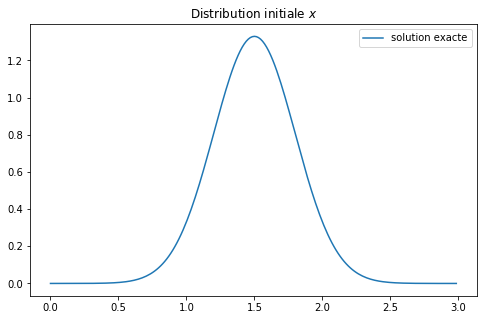

In [167]:
# taille de la figure
plt.figure(figsize=(8,5))
grid_t = np.linspace(0,tau,nt)
plt.title("Distribution initiale $x$")
plt.plot(grid, xstar, label="solution exacte")
plt.legend()
plt.show()

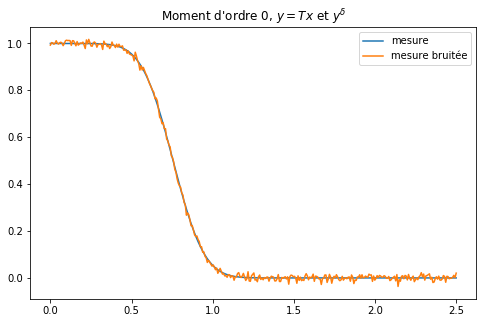

In [168]:
# taille de la figure
plt.figure(figsize=(8,5))
grid_t = np.linspace(0,tau,nt)
plt.title("Moment d'ordre 0, $y=Tx$ et $y^\delta$")
plt.plot(grid_t, y, label="mesure")
plt.plot(grid_t, yd, label="mesure bruitée")
plt.legend()
plt.show()

In [169]:
np.linalg.norm(y-yd)/np.linalg.norm(y)

0.019130139655867802

In [170]:
normH1 = l/nx*np.linalg.norm(xstar)+l/nx*np.linalg.norm(xstarp)
alpha = math.sqrt(tau/nt*np.linalg.norm(y-yd))/math.sqrt(normH1)
alpha

0.05766485216476831

In [171]:
from scipy.linalg import eigvalsh 
L = eigvalsh(tau/nt*np.transpose(T).dot(T)).max()
L

0.027482678202212823

## Forward-backward

### Explicit Forward-backward

In [172]:
def Explicit_FB(x0,f,g,df,dg,tau= 1/(2*L),eps=10**-12,Niter=10000):
    xk = x0.copy()
    yk = x0.copy()
    for k in range(Niter):
        yk = xk - tau*df(xk)
        xk = yk - tau*dg(yk)
        if np.linalg.norm(df(xk)+dg(xk))<eps:
            print("Number of iterations {}".format(k))
            return xk
    print("Final error eps = {}".format(np.abs(f(xk))))
    print("Max iteration of {} reached".format(Niter))
    return xk  

In [173]:
def f(x):
    return 0.5*tau/nt*np.linalg.norm(T.dot(x)-yd)**2
def df(x):
    return tau/nt*np.transpose(T).dot(T.dot(x)-yd)
def g(x):
    return 0.5*alpha*l/nx*np.linalg.norm(x)**2
def dg(x):
    return alpha*l/nx*x

In [174]:
x0 = np.transpose(T).dot(yd)
xhat4 = Explicit_FB(x0,f,g,df,dg)

Final error eps = 0.004122255683451469
Max iteration of 10000 reached


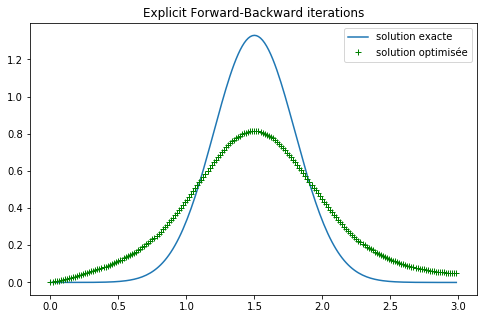

In [175]:
plt.figure(figsize=(8,5))
plt.title("Explicit Forward-Backward iterations")
plt.plot(grid, xstar, label="solution exacte")
plt.plot(grid, xhat4,'g+',label="solution optimisée")
plt.legend()
plt.show()

### Implicit Forward-backward

Option 1 :
Compute explicitly the proximal operator.
$$
f(x) = \frac{1}{2} \| Tx-y\|_Y^2
$$

$$
g(x) = \frac{1}{2} \alpha \| x\|_X^2
$$

$$ 
prox_{\gamma g}(x) = \frac{x}{\gamma \alpha+1}
$$

In [192]:
def proxg(x,gamma):
    return x/(gamma*alpha/2+1)

In [223]:
def Forward_backward(x0,df,proxg,tau=1/(2*L),eps=10**-12,Niter=10000):
    xk = x0.copy()
    yk = x0.copy()
    for k in range(Niter):
        yk = xk - tau*df(xk)
        xk = proxg(yk,1/tau)
        if np.linalg.norm(df(xk))<eps:
            print("Number of iterations {}".format(k))
            return xk
    print("Final error eps = {}".format(np.abs(f(xk))))
    print("Max iteration of {} reached".format(Niter))
    return xk  

In [224]:
x0 = np.transpose(T).dot(yd)
xhat5 = Forward_backward(x0,df,proxg)

Final error eps = 0.00024999782098274035
Max iteration of 10000 reached


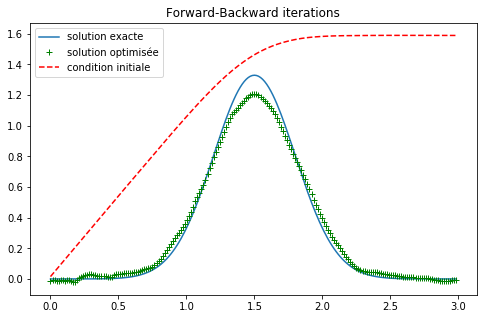

In [225]:
plt.figure(figsize=(8,5))
plt.title("Forward-Backward iterations")
plt.plot(grid, xstar, label="solution exacte")
plt.plot(grid, xhat5,'g+',label="solution optimisée")
plt.plot(grid, x0,'r--',label="condition initiale")
plt.legend()
plt.show()

On dirait que cela revient à modifier le terme de régularisation en $\alpha$...

## Douglas-Rachford

In [205]:
def proxf(x,gamma):
    return np.linalg.inv(np.eye(nx)+np.transpose(T).dot(T)).dot(x+gamma*np.transpose(T).dot(yd))/gamma

In [206]:
def Douglas_Rachford(x0,proxf,proxg,eps=10**-12,Niter=100000):
    xk = x0.copy()
    yk = x0.copy()
    for k in range(Niter):
        xk = proxf(yk,1)
        yk = yk +proxg(2*xk-yk,1) -xk
        if np.linalg.norm(df(xk)+dg(xk))<eps:
            print("Number of iterations {}".format(k))
            return xk
    print("Final error eps = {}".format(np.abs(f(xk))))
    print("Max iteration of {} reached".format(Niter))
    return xk  
    

In [207]:
x0 = np.transpose(T).dot(yd)
xhat5 = Douglas_Rachford(x0,proxf,proxg)

Final error eps = 0.0006615161107851581
Max iteration of 100000 reached


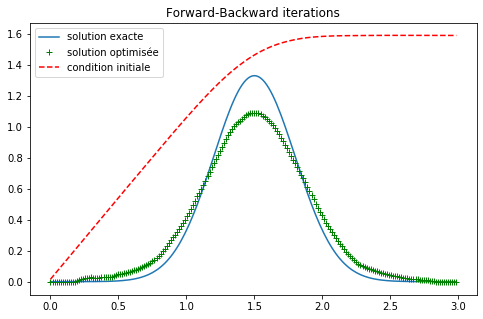

In [208]:
plt.figure(figsize=(8,5))
plt.title("Douglas-Rachford iterations")
plt.plot(grid, xstar, label="solution exacte")
plt.plot(grid, xhat5,'g+',label="solution optimisée")
plt.plot(grid, x0,'r--',label="condition initiale")
plt.legend()
plt.show()

## Chambolle-Pock